# CLOB Risk Model - Executive Summary

## Overview

This report provides a comprehensive risk analysis for perpetual futures markets, evaluating liquidity depth, volatility patterns, and stress scenarios to determine appropriate position limits.

### Methodology

Our risk framework evaluates three key dimensions:
1. **Liquidity Depth** - Available market depth at various price impact levels
2. **Volatility** - Historical price volatility using realized volatility measures
3. **Oracle Quality** - Reliability and latency of price feed infrastructure

These factors are combined into a composite risk score (1-5 scale) that drives position limit recommendations.

In [1]:
# Setup - minimal code block
import sys
sys.path.append('../src')
from risk_model import notebook_helpers as nh, chart_config as cc, plotting
from risk_model import config
import matplotlib.pyplot as plt

# Apply styling
cc.setup_chart_style()
nh.setup_pandas_display()

# Load configuration
markets_config = config.load_markets()
print(f"Analysis Date: {nh.datetime.now().strftime('%Y-%m-%d %H:%M UTC')}")

Analysis Date: 2025-12-15 09:53 UTC


## Market Data Collection

We analyze real-time market data from centralized exchanges (Binance) to assess current market conditions. This includes order book depth, trading volumes, and price history.

In [2]:
# Fetch market data
market_data = nh.fetch_market_data(markets_config['markets'], limit_markets=3)
summary_df = nh.get_market_summary(market_data)
summary_df

,Market,Price,24h Volume,Liquidity @ 1%,Volatility (%),Spread (bps)
0,ETH-PERP,3118.00,10067715029.22,11742393.19,74.56,0.03
1,BTC-PERP,89280.00,9802740746.38,10298818.25,50.98,0.01
2,SOL-PERP,131.73,2089863394.45,24376578.04,80.19,0.76


## Risk Assessment

### Risk Scoring Matrix

Each market receives scores across multiple risk factors:

- **Liquidity Score**: Based on available depth at 1% price impact
  - 1 = Very Deep (>$50M)
  - 5 = Very Shallow (<$1M)
  
- **Volatility Score**: Based on 30-day realized volatility
  - 1 = Low volatility (<30% annualized)
  - 5 = Extreme volatility (>150% annualized)
  
- **Oracle Score**: Based on feed quality and decentralization
  - 1 = Chainlink multi-source
  - 5 = Single source or unknown

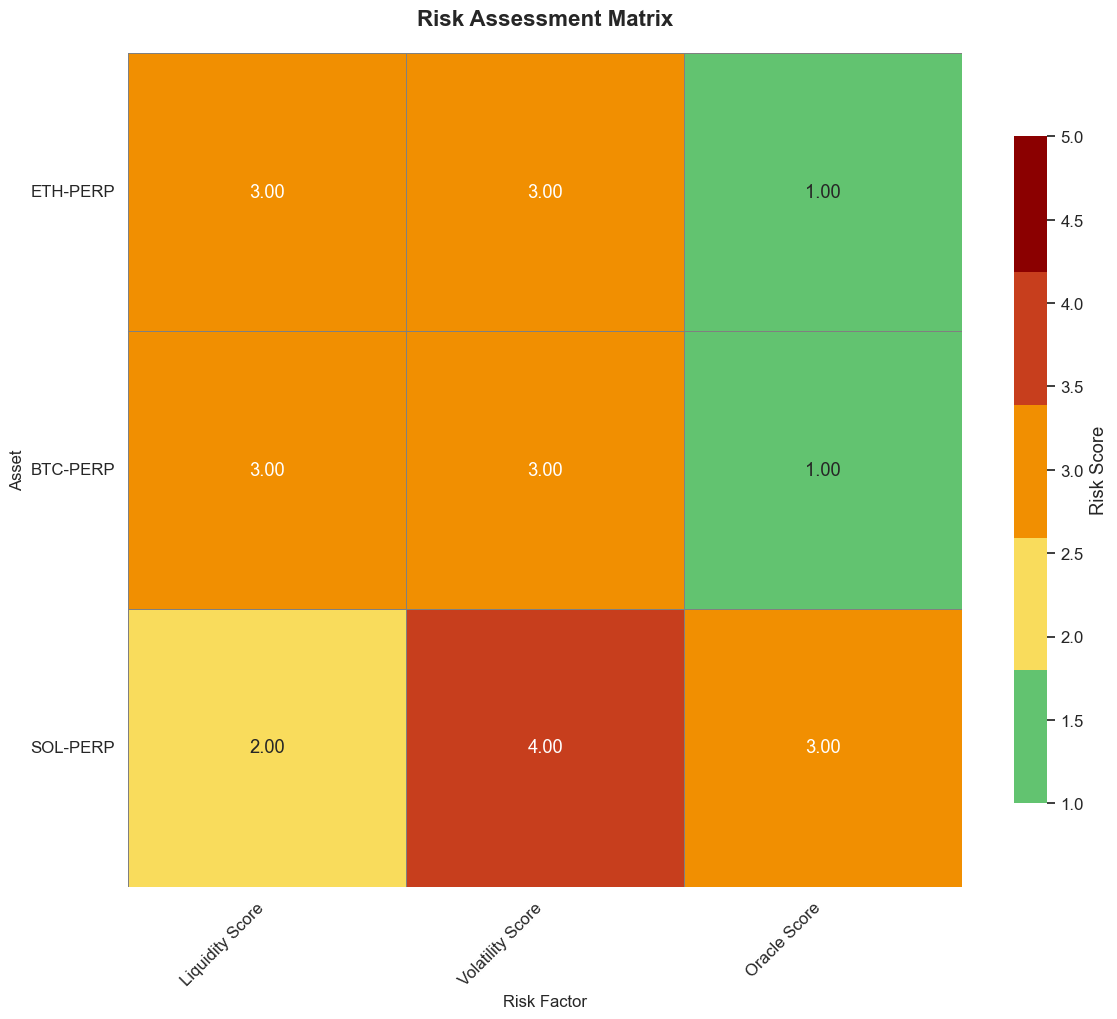

In [3]:
# Calculate and visualize risk scores
risk_df = nh.calculate_risk_metrics_all(market_data)
risk_matrix = risk_df[['Market', 'Liquidity Score', 'Volatility Score', 'Oracle Score', 'Composite Score']].set_index('Market')

fig, ax = plotting.plot_risk_heatmap(risk_matrix.iloc[:, :-1], "Risk Assessment Matrix")
plt.show()

## Position Limit Recommendations

Based on the composite risk scores, we recommend maximum open interest (OI) limits as a percentage of available liquidity:

| Risk Score | Max OI % | Description |
|------------|----------|-------------|
| 1-2        | 35-50%   | Low risk, deep liquidity |
| 3          | 25%      | Medium risk, standard limits |
| 4-5        | 7-15%    | High risk, conservative limits |

Individual position limits are set at 15% of the maximum OI to prevent concentration risk.

In [4]:
# Display position limits
limits_df = risk_df[['Market', 'Composite Score', 'Max OI (USD)', 'Max Position (USD)', 'Health Status']].copy()
limits_df['Max OI (USD)'] = limits_df['Max OI (USD)'].apply(lambda x: f'${x/1e6:.1f}M')
limits_df['Max Position (USD)'] = limits_df['Max Position (USD)'].apply(lambda x: f'${x/1e6:.1f}M')
limits_df

,Market,Composite Score,Max OI (USD),Max Position (USD),Health Status
0,ETH-PERP,3,$2.9M,$0.4M,healthy
1,BTC-PERP,3,$2.6M,$0.4M,healthy
2,SOL-PERP,3,$6.1M,$0.9M,healthy


## Market Quality Analysis

### Volatility Dynamics

Understanding volatility patterns helps calibrate risk parameters and margin requirements. Higher volatility markets require more conservative position limits and higher margins.

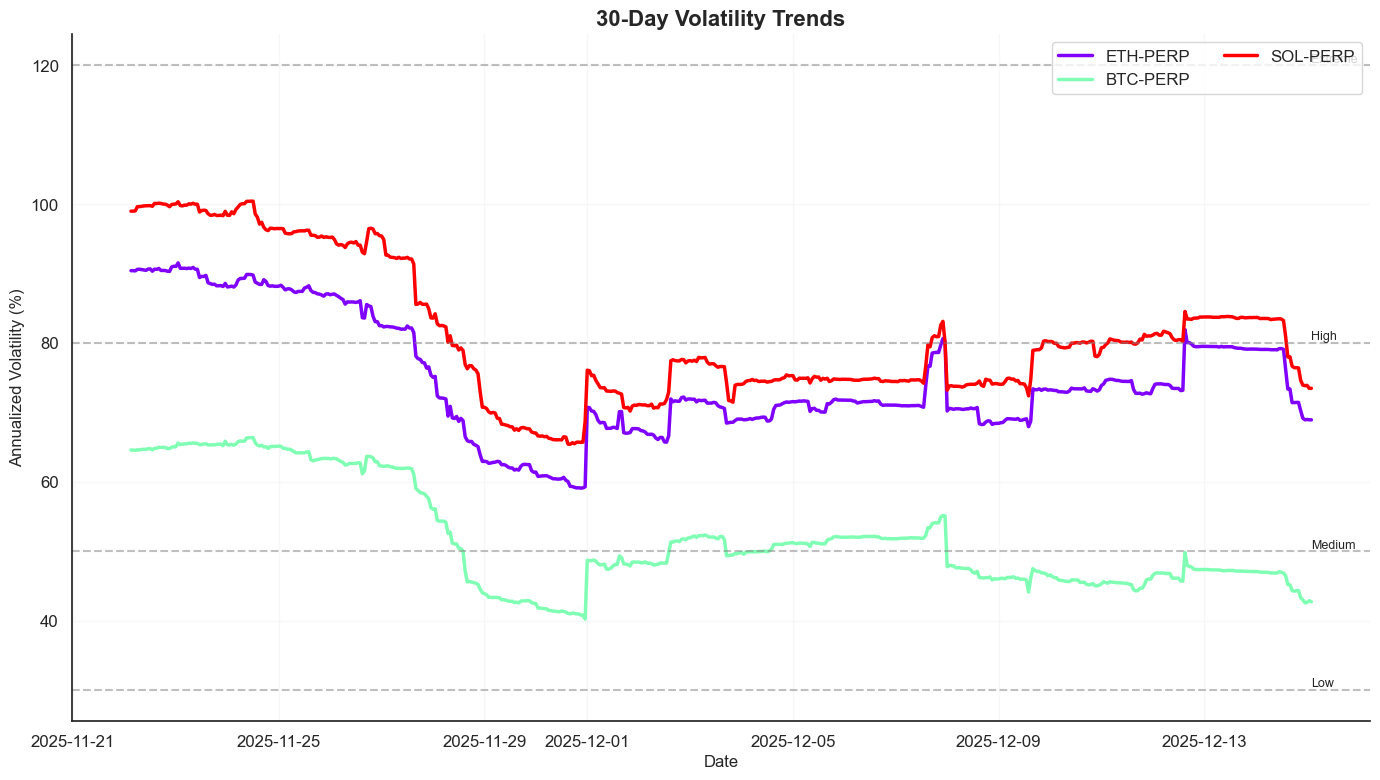

In [5]:
# Prepare volatility data for visualization
vol_data = {}
for name, data in market_data.items():
    klines = data['klines']
    returns = nh.np.log(klines['close'] / klines['close'].shift(1)).dropna()
    rolling_vol = returns.rolling(window=24*7).std() * nh.np.sqrt(365 * 24)
    vol_df = nh.pd.DataFrame(index=klines.index)
    vol_df['volatility'] = rolling_vol
    vol_data[name] = vol_df.dropna()

fig, ax = plotting.plot_volatility_surface(vol_data, "30-Day Volatility Trends")
plt.show()

## Stress Testing Results

### Scenario Analysis

We evaluate market resilience under various stress scenarios:

1. **Mass Liquidation**: What happens if 10-40% of open interest is liquidated?
2. **Price Gaps**: Impact of sudden price moves before liquidations can occur
3. **Cascade Effects**: Sequential liquidations triggering further liquidations

These scenarios help identify potential systemic risks and validate our position limits.

In [6]:
# Run stress tests for the first market
first_market = list(market_data.keys())[0]
stress_results = nh.run_stress_tests({first_market: market_data[first_market]}, 
                                   scenarios_to_run=['liquidation_20pct', 'gap_10pct'])

# Display results
for market, scenarios in stress_results.items():
    print(f"\nStress Test Results for {market}:")
    for scenario_name, result in scenarios.items():
        severity = result.get('severity', 'unknown')
        impact = result.get('avg_impact_pct', result.get('gap_pct', 0))
        print(f"  {scenario_name}: {impact:.1f}% impact ({severity} severity)")


Stress Test Results for ETH-PERP:
  liquidation_20pct: 0.0% impact (low severity)
  gap_10pct: 10.0% impact (low severity)


## Executive Summary & Recommendations

In [7]:
# Generate and display executive summary
from IPython.display import Markdown
exec_summary = nh.generate_executive_summary(market_data)
display(Markdown(exec_summary))

## Executive Summary

### Market Coverage
- **Total Markets Analyzed**: 3
- **Data Timestamp**: 2025-12-15 09:53 UTC

### Risk Distribution
- **Low Risk Markets**: 0 (Composite Score < 3)
- **Medium Risk Markets**: 3 (Composite Score 3-4)
- **High Risk Markets**: 0 (Composite Score ≥ 4)

### Key Recommendations
- **Total Recommended OI Capacity**: $11,604,447
- **Average OI/Volume Ratio**: 0.00x
- **Markets Requiring Attention**: None

### Action Items
1. Review position limits for high-risk markets
2. Monitor markets with OI/Volume ratios above 5x
3. Consider increasing liquidity buffers for volatile assets


## Implementation Guidelines

### Operational Recommendations

1. **Position Monitoring**
   - Implement real-time tracking of open interest vs limits
   - Alert when utilization exceeds 80% of limits
   - Daily review of risk scores

2. **Dynamic Adjustments**
   - Reduce limits by 50% during high volatility periods (>100% annualized)
   - Increase monitoring frequency for markets with composite scores ≥ 4
   - Review limits weekly based on market conditions

3. **Risk Controls**
   - Implement position size checks at order entry
   - Enforce single trader position limits
   - Maintain liquidity buffers for emergency scenarios

### Next Steps

1. Deploy automated monitoring systems
2. Establish governance process for limit changes
3. Conduct quarterly reviews of risk parameters
4. Develop incident response procedures

---

*This report is generated using real-time market data and should be updated regularly. Risk parameters may need adjustment based on market conditions and operational experience.*